In [4]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from random import seed
from random import random
seed(57)

#set seed for repeatability
np.random.seed(314)

In [5]:
#acquire data from CSV
usm_raw_data = pd.read_csv("C:/Users/Taylor_Vitunic/Desktop/Machine Learning/fault_detection.csv", sep = ";")
usm_raw_data.head(10)

,flatness_ratio,symmetry,crossflow,flow_velocity_path_1,flow_velocity_path_2,flow_velocity_path_3,flow_velocity_path_4,flow_velocity_path_5,flow_velocity_path_6,flow_velocity_path_7,...,gain_8,gain_9,gain_10,gain_11,gain_12,gain_13,gain_14,gain_15,gain_16,fault
0,0.841499,1.009367,0.993816,8.469805,10.178717,10.037759,8.501365,8.581716,10.147763,10.058812,...,31.451173,34.568685,33.081683,36.711005,36.969403,36.075847,36.051432,35.174155,31.719490,0
1,0.841150,1.006584,0.996605,7.531891,9.139914,8.951618,7.611112,7.613315,9.106345,8.945142,...,31.418385,34.441732,33.081055,36.687815,36.933595,36.054688,35.979818,34.847005,31.731112,0
2,0.840713,1.011647,0.998152,6.641699,7.975464,7.857692,6.593117,6.681571,7.964596,7.814698,...,31.418385,34.175715,33.113605,36.661785,36.873370,36.001605,35.963542,34.689118,31.771810,0
3,0.841119,1.017807,0.996812,5.687514,6.814334,6.689885,5.615418,5.763315,6.801051,6.686639,...,31.485350,34.080403,33.170573,36.673177,36.811515,35.974935,35.955403,34.500318,31.849935,0
4,0.840358,1.016534,0.996111,5.660385,6.819560,6.675618,5.613977,5.736818,6.813453,6.671377,...,31.503155,34.111710,33.164062,36.673177,36.816173,35.996095,35.968415,34.474183,31.853190,0
5,0.838901,1.014557,0.995404,5.646000,6.830114,6.660116,5.630101,5.711871,6.813999,6.693988,...,31.495117,34.103192,33.168945,36.666668,36.817800,35.997712,35.958658,34.488932,31.849935,0
6,0.841544,1.010160,0.995604,5.618586,6.811160,6.685119,5.671933,5.718375,6.811300,6.671610,...,31.501617,34.103190,33.185112,36.668195,36.819418,35.999352,35.947167,34.480795,31.861317,0
7,0.840916,1.015113,0.995890,5.647400,6.811408,6.675509,5.613755,5.740677,6.795750,6.670478,...,31.488608,34.098308,33.167310,36.676432,36.811910,36.015615,35.930988,34.458007,31.867840,0
8,0.841671,1.008904,0.994111,5.613118,6.815111,6.681615,5.680006,5.716151,6.817909,6.695648,...,31.504883,34.111318,33.161433,36.663413,36.816172,35.991838,35.970053,34.487307,31.859700,0
9,0.835900,1.014731,0.997580,4.744331,5.749815,5.615156,4.719561,4.810332,5.711404,5.641602,...,31.534182,33.979493,33.104753,36.669912,36.785485,35.970053,35.944012,34.183855,31.910158,0


In [6]:
#convert data
usm_data = usm_raw_data.to_numpy()

In [7]:
#check shape
usm_data.shape

(87, 37)

In [8]:
#get USM data into workable numpy

A=[]

for i in range(0,87):
    C=[]
    for j in range(0,37):
        C.append(usm_data[i,j])
    A.append(C)
        
A = np.array(A)

#shuffle array since it is ordered by failure
#when we take 70/87 samples later from random shuffle we will have KFold = 5
np.random.shuffle(A)

In [9]:
#normalize data to make learning easier

#def normalize(num, avg, stddev):
#    return (num-avg)/stddev

description = usm_raw_data.describe()
avg = np.array(description.T['mean'])
std = np.array(description.T['std'])

for i in range(0,87):
    for j in range(0,36):
        A[i,j] = (A[i,j] - avg[j])/std[j]

In [10]:
#build neural network, relu for speed+accuracy, sigmoid at end to ensure answer is between 0 to 1

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid"),
])

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = "adam",
    metrics = ["accuracy"]
)

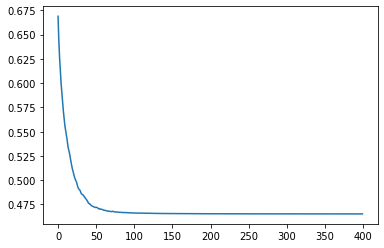

In [11]:
#run neural network

history = model.fit(A[:70,:36], A[:70,36], epochs=400, verbose=0, shuffle=True)
plt.plot(history.history["loss"])

In [12]:
#predict working/faulty for test set
#where 1 is faulty, 0 is working
predictions = model.predict(A[70:,:36])
predictions = [1 if p >=.5 else 0 for p in predictions]
print(predictions)

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]


In [13]:
#actuals working/faulty in the test set
#bifurcated training and testing data at 70/87 = ~80% split
actuals = A[70:,36]
print(actuals)

[0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.]


In [14]:
#take stock of accuracy of predictions
correct = 0
t1 = 0
t2 = 0
total = len(predictions)

#correct is correctly predicted if meter is faulty or not
#type 1 error = predicting meter is faulty when it is not
#type 2 error = predicting meter is not faulty when it is

for i in range(0, total):
    
    if (predictions[i]==actuals[i]):
        correct += 1
    elif (predictions[i]>=actuals[i]):
        t1 += 1
    else:
        t2 += 1
print("We got {}/{} correct with {}/{} type 2 errors and {}/{} type 1 errors".format(correct,total,t1,total,t2,total))

We got 13/17 correct with 0/17 type 2 errors and 4/17 type 1 errors
